Model Workflow
Data Loading &  Processing
()


Data source: ccxt for real-time and historical data on OHLCV(open, high, low, closing & volume data) for digital currency (e.g. BTC) using a 1d (daily) timeframe 
Feature Engineering : calculate price, volume & volatility-based indicators 
- Price: Simple Moving Average(SMA), EMA, RSI, MACD (for momentum signals)
--> RSI: measure 
- Volume: OBV (On-Balance Volume), Money Flow Index (MFI)
- Volatility: ATR (Average True Range), Bollinger Bands Width(BBW)

Further Feature engineering: implementing Time Series 

- Add weighted averages based on regression of lagged values, using partial autocorrelation (PACF) to identify autoregressive lags for feature selection
- Implement time-series modelling to forecast short-term price movements using ARIMA, & selecting best ARIMA model based on AIC/BIC criteria to obtain parameters (p - autoregressive order & q - simple moving average order)
Filling missing data with interpolation & normalization

Feature Selection through Pre-calculated Technical Indicators 

Trend prediction: inputs - SMA, EMA, using Linear regression (OLS), or support vector machine
Market Regime Detection: inputs - RSI, ATR, SMA using K-means Clustering
Buy/Sell Signals for Binary Classification: inputs - RSI, MACD, OBV, using Random Forest Classifier 

Model Training & Prediction: Machine Learning

Time Series Modelling: ARIMA for short -term price, GARCH for volatility forecasting 
Price Forecasting: LSTM, utilizing keras to implement long-term price forecasting
Strategy Implementation:
Combine signals and implement reinforcement learning to create a trading strategy

Momentum Oscillators(BUY/SELL SIGNALS)
RSI: 
Purpose: Measures the speed & change of price movements.
Use Case: Buy if RSI < 30 (oversold), Sell if RSI > 70 (overbought)
MACD:
Purpose: Identifies trend reversals via moving average crossovers.
Use Case: Buy if MACD crosses above Signal Line, Sell if MACD crosses below Signal Line
(other indicators we have not considered)
Stochastic Oscillator(STOCH)
Purpose: Identifies overbought & oversold conditions based on recent highs/lows.
Use Case: Buy if %K crosses above %D in oversold zone (<20), Sell if %K crosses below %D in overbought zone (>80)
Rate of Change (ROC)
Purpose: Measures the percentage change of price over a given period.
Use Case: Buy when ROC turns positive, Sell when ROC turns negative.

Volitility Indicators 
Bollinger Bands:
Purpose: Measures price volatility relative to a moving average.
Use Case: Buy when price touches lower band, Sell when price touches upper band.
Average True Range (ATR)
Purpose: Measures market volatility by averaging true range values.
Use Case: High ATR → High volatility, Low ATR → Low volatility.

Volume Indicators 
On-Balance Volume (OBV)
Purpose: Cumulative volume indicator that tracks buying/selling pressure.
Use Case: Rising OBV suggests buying pressure, declining OBV suggests selling pressure.
Money Flow Index (MFI)
Purpose: Volume-weighted RSI to assess buying/selling pressure.
Use Case: Buy if MFI < 20, Sell if MFI > 80


In [5]:
#Data Loading
import ccxt
import pandas as pd
import time
from datetime import datetime, timedelta

# Initialize exchange
exchange = ccxt.binance()

# Define symbol and timeframe
symbol = 'BTC/USDT'
timeframe = '1d'

# Calculate timestamp for 1 year ago 
end_date = datetime(2025, 2, 28)  # Last day of February 2025
start_date = end_date - timedelta(days=365)  

# Convert to milliseconds (Binance API uses Unix timestamp in milliseconds)
since = int(start_date.timestamp() * 1000)

# Fetch historical OHLCV data
ohlcv = exchange.fetch_ohlcv(symbol, timeframe, since=since)

# Convert to DataFrame
data = pd.DataFrame(ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
data['timestamp'] = pd.to_datetime(data['timestamp'], unit='ms')
data.set_index('timestamp', inplace=True)

# Display the first few rows
print(data.head())
print(data.tail())  # Check the latest date to ensure correct range


                open      high       low     close       volume
timestamp                                                      
2024-02-29  62432.11  63676.35  60364.70  61130.98  78425.07603
2024-03-01  61130.99  63114.23  60777.00  62387.90  47737.93473
2024-03-02  62387.90  62433.19  61561.12  61987.28  25534.73659
2024-03-03  61987.28  63231.88  61320.00  63113.97  28994.90903
2024-03-04  63113.97  68499.00  62300.00  68245.71  84835.16005
                open      high       low     close       volume
timestamp                                                      
2025-03-08  86801.74  86897.25  85218.47  86222.45  12989.23054
2025-03-09  86222.46  86500.00  80000.00  80734.37  26115.39345
2025-03-10  80734.48  84123.46  77459.91  78595.86  47633.38405
2025-03-11  78595.86  83617.40  76606.00  82932.99  48770.06853
2025-03-12  82932.99  83783.26  81617.76  81792.08   5849.47496


In [9]:
#Calculation of Technical Indicators
from ta.trend import SMAIndicator, EMAIndicator, MACD
from ta.momentum import RSIIndicator
from ta.volatility import BollingerBands, AverageTrueRange
from ta.volume import OnBalanceVolumeIndicator, VolumeWeightedAveragePrice, money_flow_index
import numpy as np
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler


# Calculate technical indicators
def calculate_technical_indicators(data):
    data['SMA'] = SMAIndicator(data['close'], window=14).sma_indicator()
    data['EMA'] = EMAIndicator(data['close'], window=14).ema_indicator()
    data['RSI'] = RSIIndicator(data['close'], window=14).rsi()
    macd = MACD(data['close'], window_fast=12, window_slow=26, window_sign=9)
    data['MACD'] = macd.macd() 
    data['MACD_signal'] = macd.macd_signal()
    data['MACD_hist'] = macd.macd_diff()
    data['OBV'] = OnBalanceVolumeIndicator(data['close'], data['volume']).on_balance_volume()
    data['MFI'] = money_flow_index(data['high'], data['low'], data['close'], data['volume'], window=14)
    data['ATR'] = AverageTrueRange(data['high'], data['low'], data['close'], window=1).average_true_range()
    bands = BollingerBands(data['close'], window=20, window_dev = 2)
    data['upper_band'] = bands.bollinger_hband()
    data['middle_band'] = bands.bollinger_mavg()
    data['lower_band'] = bands.bollinger_lband() 
    data['BBW'] = (data['upper_band'] - data['lower_band']) / data['middle_band']
    return data 
#handle missing values
def handle_missing_data(data):
    data.fillna(method = 'ffill', inplace=True)
    data.fillna(method = 'bfill', inplace = True)
    return data 

# Normalization
def normalize_data(df):
    scaler = MinMaxScaler()
    df[['close', 'SMA', 'EMA', 'RSI', 'MACD', 'OBV', 'ATR']] = scaler.fit_transform(df[['close', 'SMA', 'EMA', 'RSI', 'MACD', 'OBV', 'ATR']])
    return df

btc_data = calculate_technical_indicators(data)
btc_data = handle_missing_data(btc_data)
btc_data = normalize_data(btc_data)

#inspect data
print(btc_data.head()) 
print(btc_data.tail())
print(btc_data.info())


                open     high       low     close         volume       SMA  \
timestamp                                                                    
2024-03-05  68245.71  69000.0  59005.00  0.187062  132696.781300  0.248158   
2024-03-06  63724.01  67641.1  62779.14  0.232098   78738.854910  0.248158   
2024-03-07  66074.04  67980.0  65551.00  0.246454   53059.886900  0.248158   
2024-03-08  66823.18  69990.0  66082.66  0.271387   74261.932842  0.248158   
2024-03-09  68124.20  68541.1  67861.10  0.275011   19872.897430  0.248158   

                 EMA       RSI      MACD  MACD_signal  ...  upper_band  \
timestamp                                              ...               
2024-03-05  0.239854  0.462488  0.425243     0.011027  ...    0.373334   
2024-03-06  0.239854  0.462488  0.425243     0.011027  ...    0.373334   
2024-03-07  0.239854  0.462488  0.425243     0.011027  ...    0.373334   
2024-03-08  0.239854  0.462488  0.425243     0.011027  ...    0.373334   
2024-03-0

C:\Users\alyss\AppData\Local\Temp\ipykernel_1888\2446309484.py:33: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method = 'ffill', inplace=True)
C:\Users\alyss\AppData\Local\Temp\ipykernel_1888\2446309484.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method = 'bfill', inplace = True)


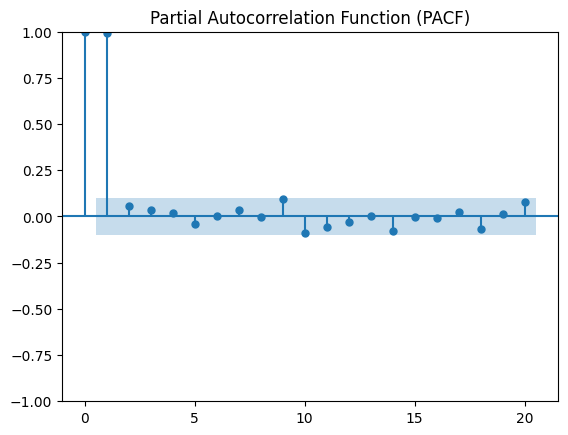

In [10]:
# Calculate weighted averages using regression on lagged values
def calculate_weighted_averages(data, lags):
    for i in range(1, lags + 1):
        data[f'lag_{i}'] = data['close'].shift(i)
    data.dropna(inplace=True)

    X = data[[f'lag_{i}' for i in range(1, lags + 1)]]
    y = data['close']
    model = LinearRegression()
    model.fit(X, y)
    weights = model.coef_
    data['weighted_avg'] = np.dot(X, weights)

calculate_weighted_averages(btc_data, 5)

# Plot PACF to identify autoregressive lags
plot_pacf(data['close'], lags=20)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

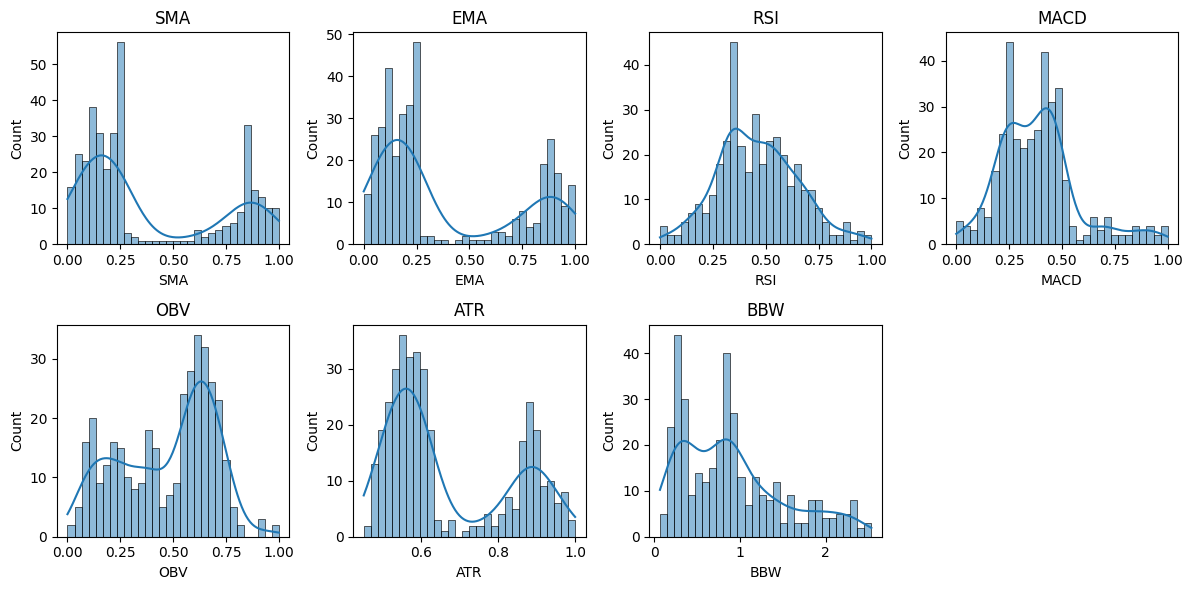

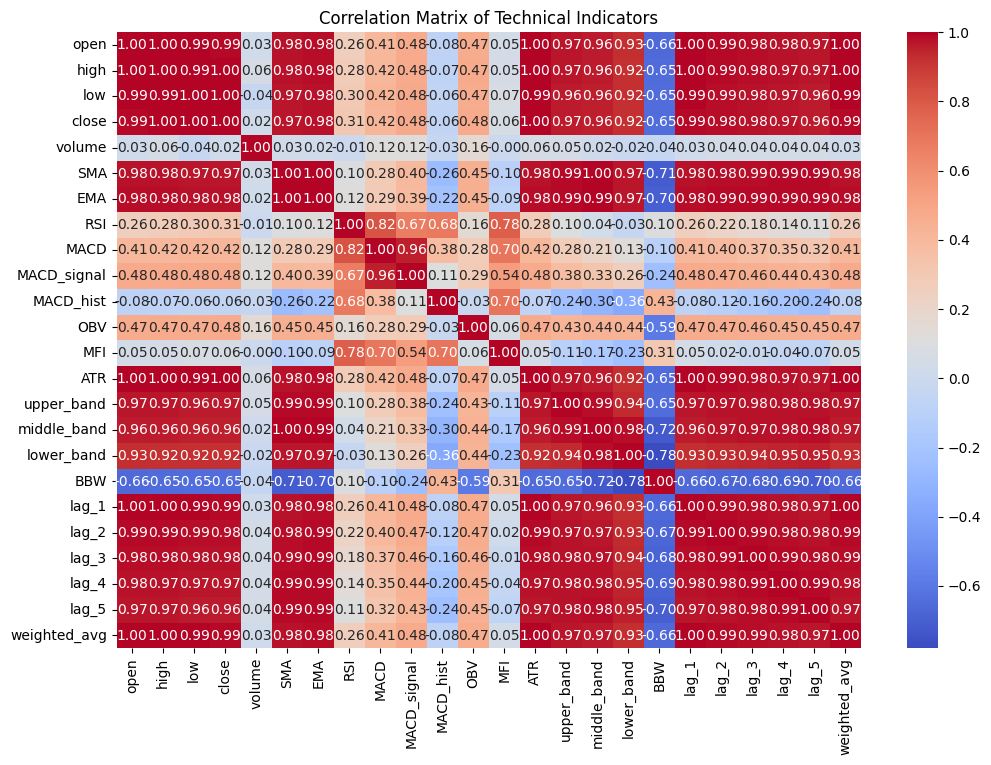

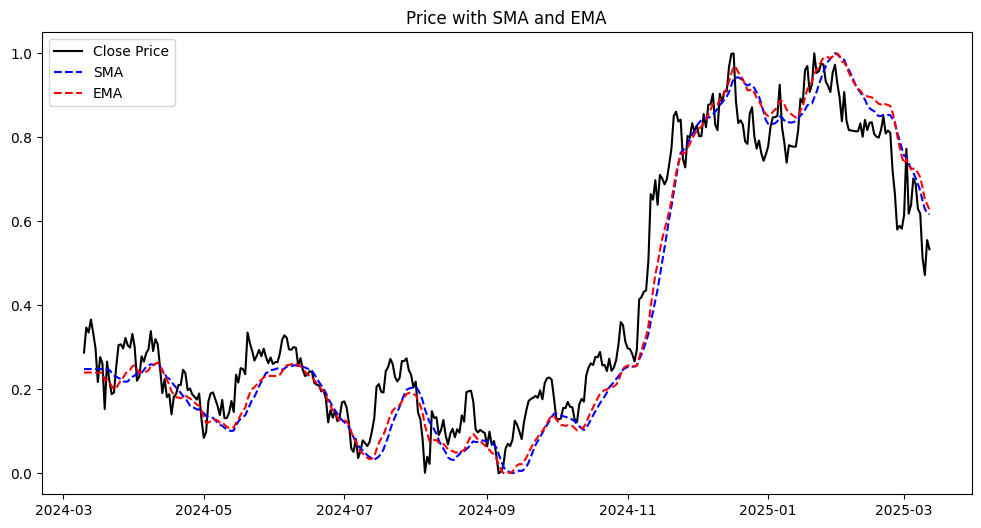

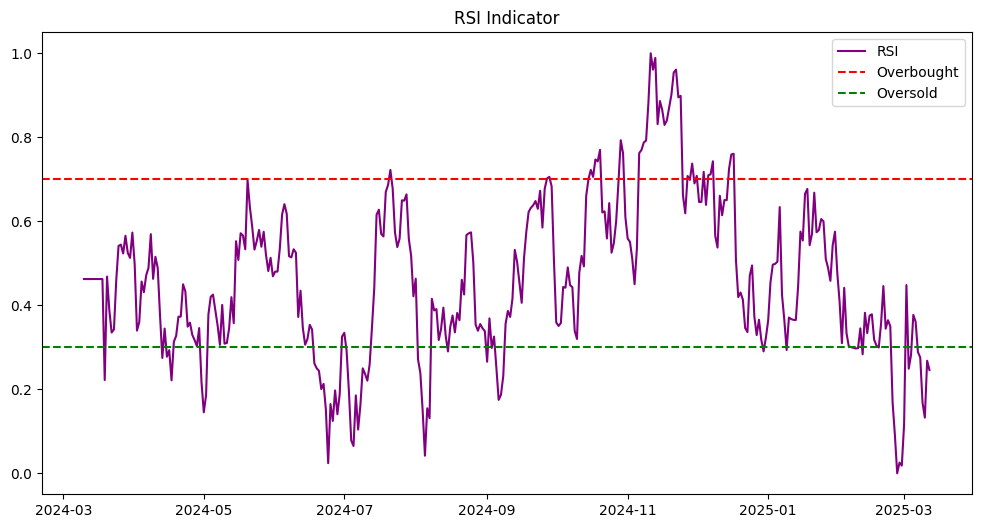

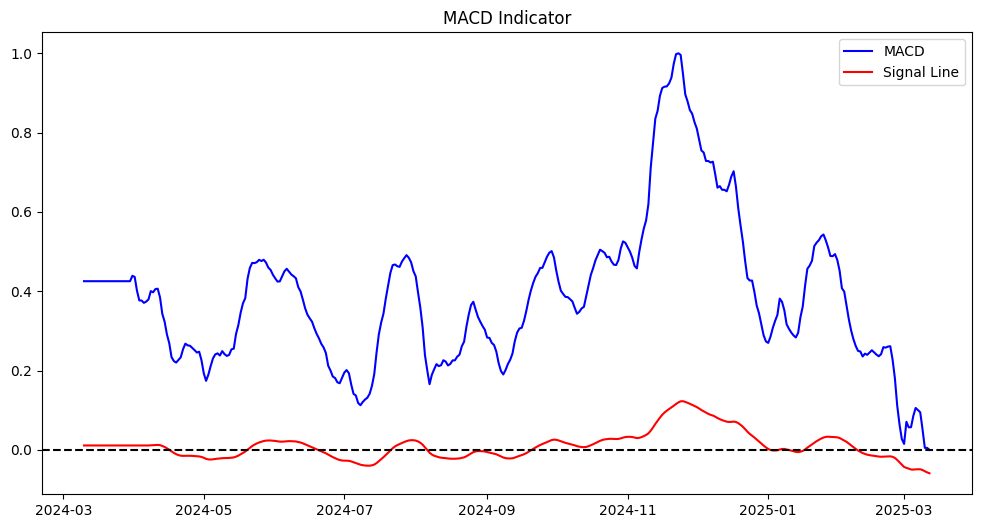

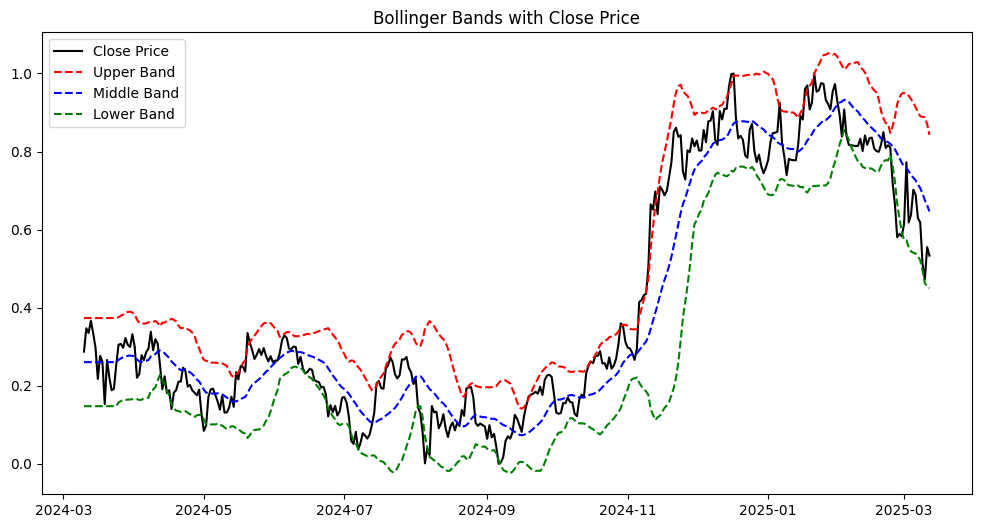

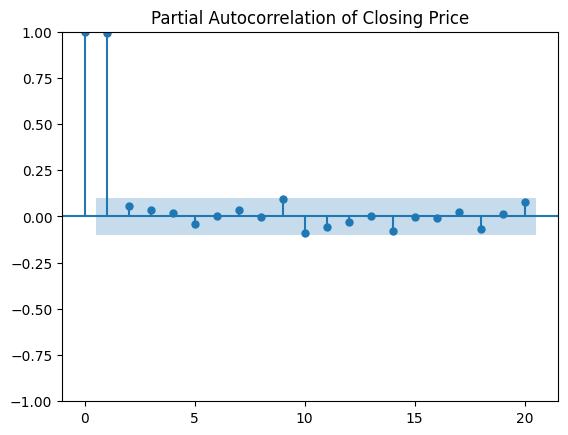

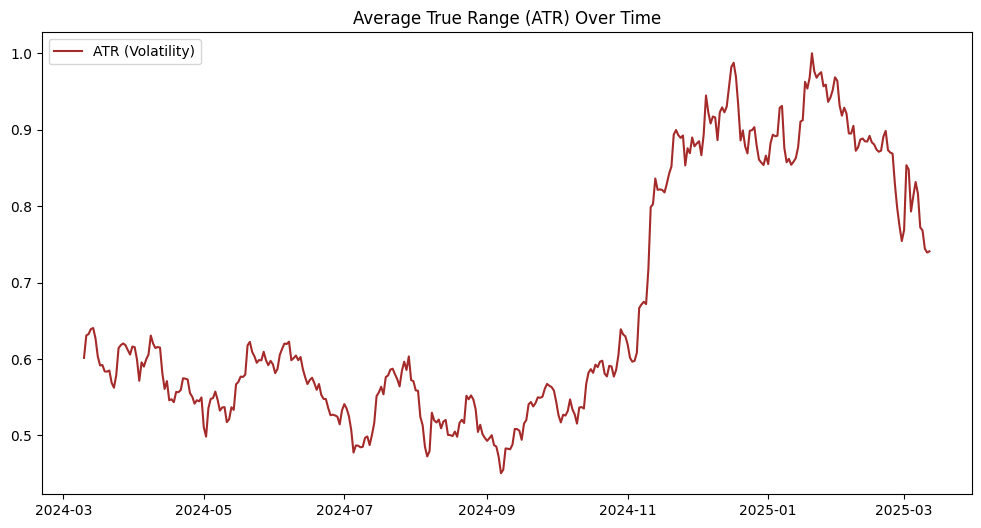

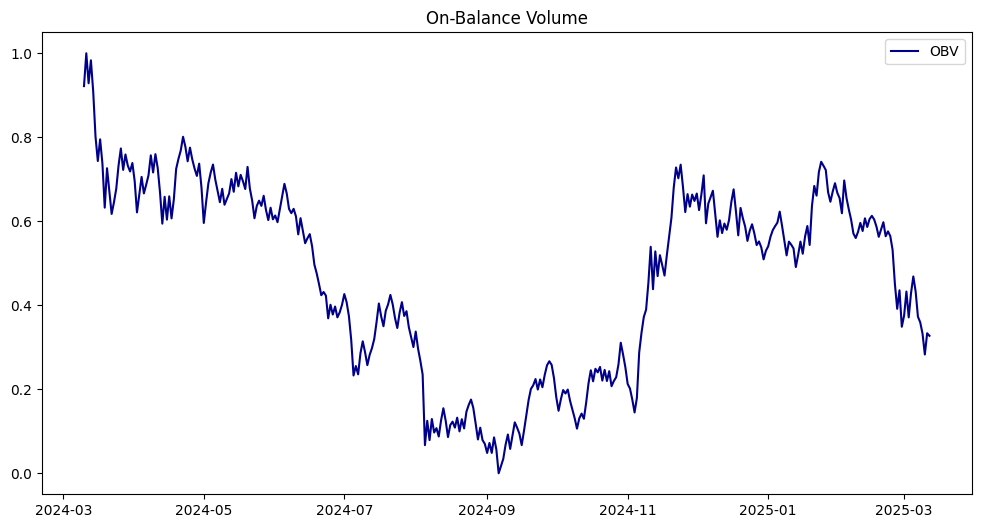

In [12]:
#EDA
import seaborn as sns
import matplotlib.pyplot as plt 

data = btc_data

#Distribution of Each Indicaor 
indicators = ['SMA', 'EMA', 'RSI', 'MACD', 'OBV', 'ATR', 'BBW']  # Select key indicators

plt.figure(figsize=(12, 6))
for i, indicator in enumerate(indicators):
    plt.subplot(2, 4, i + 1)
    sns.histplot(data[indicator], kde=True, bins=30)
    plt.title(indicator)
plt.tight_layout()
plt.show()

#Check for Correlations(Feature Redundancy)
#Some indicators might be highly correlated, making them redundant
#If correlation > 0.85, remove one of the correlated features.
# Example: SMA and EMA are usually correlated → Keep only one.
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix of Technical Indicators")
plt.show()

#Comparing Indicators with closing prices (Plot Trends Over Time)
# Check how SMA and EMA interact with price.
# Identify points where indicators signal trend reversals.

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['close'], label='Close Price', color='black')
plt.plot(data.index, data['SMA'], label='SMA', linestyle='dashed', color='blue')
plt.plot(data.index, data['EMA'], label='EMA', linestyle='dashed', color='red')
plt.legend()
plt.title("Price with SMA and EMA")
plt.show()

#Identify Overbought & Oversold Conditions (RSI & MACS)
# A. RSI (Relative Strength Index)
# RSI > 70 → Overbought (possible sell signal)
# RSI < 30 → Oversold (possible buy signal)
# Are most RSI values in a normal range (30-70)?
# Do RSI peaks align with price reversals?
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['RSI'], label="RSI", color="purple")
plt.axhline(0.7, linestyle="dashed", color="red", label="Overbought")
plt.axhline(0.3, linestyle="dashed", color="green", label="Oversold")
plt.legend()
plt.title("RSI Indicator")
plt.show()

# B. MACD (Moving Average Convergence Divergence)
# MACD > Signal Line → Bullish
# MACD < Signal Line → Bearish
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['MACD'], label='MACD', color='blue')
plt.plot(data.index, data['MACD_signal'], label='Signal Line', color='red')
plt.axhline(0, linestyle="dashed", color="black")
plt.legend()
plt.title("MACD Indicator")
plt.show()


#Analyze Bollinger Bands(Volatility)
# Price above upper band → Overbought
# Price below lower band → Oversold
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['close'], label='Close Price', color='black')
plt.plot(data.index, data['upper_band'], label='Upper Band', linestyle='dashed', color='red')
plt.plot(data.index, data['middle_band'], label='Middle Band', linestyle='dashed', color='blue')
plt.plot(data.index, data['lower_band'], label='Lower Band', linestyle='dashed', color='green')
plt.legend()
plt.title("Bollinger Bands with Close Price")
plt.show()

#Aurocorrelation & Seasonality
#Check if past price values influence future prices using Partial Autocorrelation (PACF).
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data['close'], lags=20)
plt.title("Partial Autocorrelation of Closing Price")
plt.show()

#Detect Market Regimes
# High ATR = High volatility (trend breakout).
# Low ATR = Sideways market
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['ATR'], label="ATR (Volatility)", color="brown")
plt.legend()
plt.title("Average True Range (ATR) Over Time")
plt.show()

#Volume & Trend Analysis
# A. On-Balance Volume (OBV)
# Check if OBV trends match price movements.
# Action:
# OBV rising = Accumulation (bullish).
# OBV falling = Distribution (bearish).
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['OBV'], label="OBV", color="darkblue")
plt.legend()
plt.title("On-Balance Volume")
plt.show()

